In [1]:
from utils import generate_world_pandas, generate_world
import ploting as draw
import random
import numpy as np

In [506]:
# Observed Value 1, Uncertainty 1, Observed Value 2, Uncertainty 2
features = 3

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U12'), dtype('<U16')) -> None

In [504]:
list(np.array(list(zip([f'Observed Value {i}' for i in range(1, features+1)], [f'Uncertainty {i}' for i in range(1, features+1)]))).flatten())

['Observed Value 1',
 'Uncertainty 1',
 'Observed Value 2',
 'Uncertainty 2',
 'Observed Value 3',
 'Uncertainty 3']

In [312]:
world_coords = generate_world_bounds(features = 2)
class_number  = 10
bounds_with_class = {}
random_list = list(np.arange(class_number)) + [np.random.randint(0, class_number - 1) for _ in range(len(world_coords) - class_number)]
np.random.shuffle(random_list)
for i, bounds in zip(random_list, world_coords):
    bounds_with_class[bounds] = i

In [461]:
from collections import defaultdict
class_with_bounds = defaultdict(set)
bounds_with_class
for bounds, cls in bounds_with_class.items():
    class_with_bounds[cls] |= {bounds}
    
bounds_set = set()
for b in class_with_bounds.values():
    bounds_set |= b
for _ in range(10):
    bound = random.choice(list(bounds_set))
    for cls, bounds in class_with_bounds.items():
        if bound in bounds:
            break
    val = [random.uniform(minV, maxV) for minV, maxV in bound]
    print(np.array([cls] + val))

[3.         0.09995382 0.72381818]
[9.         0.60934193 0.46028849]
[4.         0.36898648 0.18811591]
[3.         0.34734291 0.76823435]
[4.         0.34172133 0.17756643]
[9.         0.95533672 0.4113466 ]
[7.         0.11463499 0.62764401]
[4.         0.48132586 0.179158  ]
[4.         0.35052069 0.47489546]
[3.         0.75273978 0.92759345]


In [4]:
def add_noise_old(tv, errRange = 1, mutation_rate = 0):
    
    def add_unc_single_value(tv, errRange, mutation_rate):
        rv = random.random() if random.random() < mutation_rate else tv 
        rv += errRange * random.uniform(-1, 1)
        return rv
    
    def add_unc_array(tv, errRange, mutation_rate):
        rv = []
        for t in tv:
            rv.append(add_unc_single_value(t, errRange, mutation_rate))
        return np.array(rv)
    
    try:
        iter(tv)
    except:
        _add_unc = add_unc_single_value
    else:
        _add_unc = add_unc_array
    
    return _add_unc(tv, errRange, mutation_rate)

In [20]:
def add_noise(world, errRange = 1, mutation_rate = 0):
    _, n_feat = world[:, 1:].shape
    for i, cls_feat in enumerate(world):
        mutation = True if random.random() < mutation_rate else False
        if mutation:
            for j in range(1, n_feat + 1):
                cls_feat[j] = random.random() + errRange * random.uniform(-1, 1)
        else:
            for j in range(1, n_feat + 1):
                cls_feat[j] += errRange * random.uniform(-1, 1)
        world[i] = cls_feat
    return world

In [5]:
import matplotlib.pyplot as plt

def draw_combined_world(data, sample_data = None, cmap='viridis'):    
    # Extracting data for the true world
    true_classes = data[:, 0]
    true_f1 = data[:, 1]
    true_f2 = data[:, 2]
    
    # Extracting data for the observed worlds
    real_f1 = data[:, 3]
    real_f2 = data[:, 4]
    
    minf1 = np.min([true_f1, real_f1])
    maxf1 = np.max([true_f1, real_f1])
    minf2 = np.min([true_f2, real_f2])
    maxf2 = np.max([true_f2, real_f2])
    
    # Creating subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
        
    axs[0].set_xlim(minf1, maxf1)
    axs[1].set_xlim(minf1, maxf1)
    
    axs[0].set_ylim(minf2, maxf2)
    axs[1].set_ylim(minf2, maxf2)
    
    # True World
    axs[0].scatter(true_f1, true_f2, c=true_classes, cmap=cmap, edgecolor='k', marker='s')
    axs[0].set_xlabel('Feature 1')
    axs[0].set_ylabel('Feature 2')
    axs[0].set_title('True World')
    
    # Observed World
    axs[1].scatter(real_f1, real_f2, c=true_classes, cmap=cmap, edgecolor='k', marker='s')
    axs[1].set_xlabel('Feature 1')
    axs[1].set_ylabel('Feature 2')
    axs[1].set_title('Real World')
    
    plt.tight_layout()
    
    # Display the plot
    plt.show()

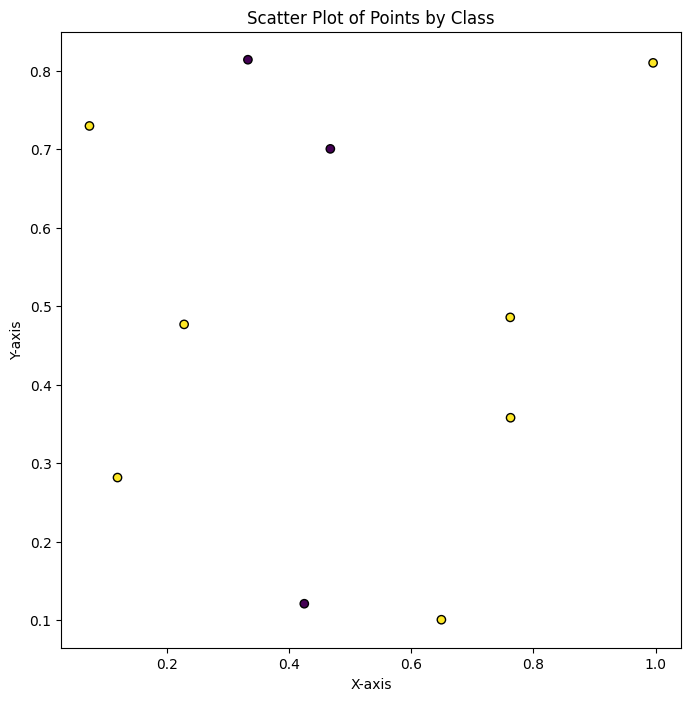

In [5]:
world = generate_world(1, 0, 2, no_samples=10, equal_classes=False)
# print(world)
# world = add_noise(world, errRange=0.05, mutation_rate=0.1)
# r = 0.9
# y1 = r*world[:, 1]+np.sqrt(1-r*r)*world[:, 1] 
# world = np.c_[world, add_noise(world[:, 1], errRange=0.05, mutation_rate=0.1)]
# world = np.c_[world, add_noise(world[:, 2], errRange=0.05, mutation_rate=0.1)]

# world[:, 1] = add_noise(world[:, 1], errRange=0.05, mutation_rate=0.1)
# world[:, 2] = add_noise(world[:, 2], errRange=0.05, mutation_rate=0.1)

# print(np.corrcoef(world[:, 1], world[:, 3])[0, 1])
draw.draw_true_world(world)

In [4]:
generate_world_pandas(1, 0, 2, no_samples=10, equal_classes=False)

,Class,True Value 1,True Value 2,Observed Value 1,Uncertainty 1,Observed Value 2,Uncertainty 2
0,0.0,0.467596,0.700637,0.554127,0.086531,0.760955,0.060319
1,1.0,0.762159,0.485928,0.670312,0.091846,0.545556,0.059629
2,1.0,0.762692,0.358049,0.678683,0.084009,0.333839,0.024211
3,1.0,0.119156,0.281838,0.201962,0.082806,0.300511,0.018673
4,0.0,0.424963,0.121082,0.392442,0.032520,0.112099,0.008982
5,1.0,0.996042,0.810217,0.939290,0.056751,0.717879,0.092338
6,1.0,0.073225,0.729832,0.087475,0.014249,0.822140,0.092308
7,1.0,0.649420,0.100701,0.748743,0.099322,0.048244,0.052457
8,0.0,0.332672,0.814224,0.277545,0.055127,0.903728,0.089504
9,1.0,0.228214,0.477010,0.146767,0.081447,0.522066,0.045056


In [67]:
np.corrcoef(world[:, 1], world[:, 3])[0,1]

0.9808630662046044